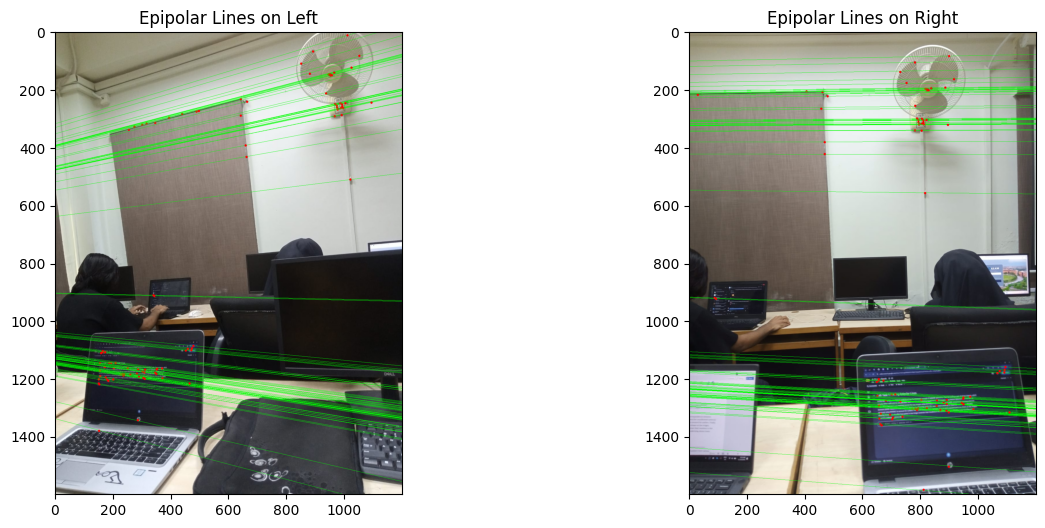

In [1]:
### TASK 1 CODE STARTS HERE ###

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
img1 = cv2.imread('/content/1.jpg')
img2 = cv2.imread('/content/2.jpg')

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# SIFT detector
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# Feature matching
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Lowe's ratio
good = []
pts1 = []
pts2 = []

for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

# Find Fundamental Matrix
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Select inliers
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

# Function to draw epipolar lines
def draw_epipolar(img, lines, pts):
    h, w = img.shape[:2]
    img = img.copy()

    for r, pt in zip(lines, pts):
        a, b, c = r
        x0, y0 = map(int, [0, -c/b])
        x1, y1 = map(int, [w, -(c + a*w)/b])
        img = cv2.line(img, (x0, y0), (x1, y1), (0,255,0), 1)
        img = cv2.circle(img, (pt[0], pt[1]), 4, (0,0,255), -1)
    return img

# Compute epipolar lines
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, F)
lines1 = lines1.reshape(-1,3)

lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1, F)
lines2 = lines2.reshape(-1,3)

# Draw on images
img1_epi = draw_epipolar(img1, lines1, pts1)
img2_epi = draw_epipolar(img2, lines2, pts2)

plt.figure(figsize=(15,6))
plt.subplot(121); plt.imshow(img1_epi[:,:,::-1]); plt.title("Epipolar Lines on Left")
plt.subplot(122); plt.imshow(img2_epi[:,:,::-1]); plt.title("Epipolar Lines on Right")
plt.show()

### TASK 1 SCREENSHOT STARTS HERE ###


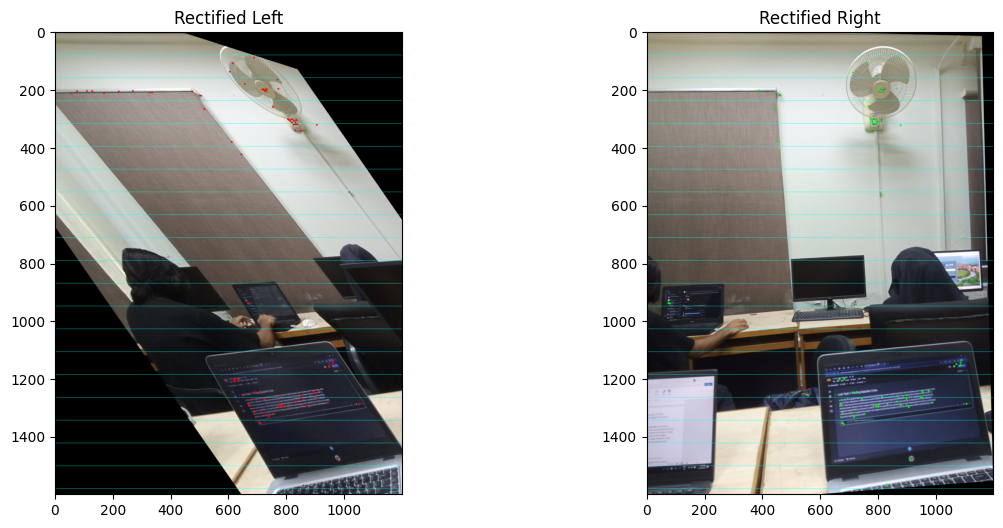

In [2]:
# --- ASSUMES you already have:
# img1, img2           : original color images (BGR)
# pts1, pts2           : Nx2 arrays of matched inlier points (int or float)
# F                    : 3x3 Fundamental matrix from findFundamentalMat
# (from Task 1 code above)

import cv2
import numpy as np

# image size (width, height)
h, w = img1.shape[:2]
imgSize = (w, h)

# stereoRectifyUncalibrated requires points in homogeneous shape (Nx1x2)
pts1f = np.float32(pts1).reshape(-1,1,2)
pts2f = np.float32(pts2).reshape(-1,1,2)

# Compute homographies H1, H2 that rectify the two images (uncalibrated)
retval, H1, H2 = cv2.stereoRectifyUncalibrated(pts1f, pts2f, F, imgSize)

if not retval:
    print("Rectification failed (insufficient or degenerate matches).")
else:
    # Warp images to rectified views
    rectified1 = cv2.warpPerspective(img1, H1, imgSize)
    rectified2 = cv2.warpPerspective(img2, H2, imgSize)

    # (Optional) warp keypoints so you can draw/check corresponding points
    def warp_points(pts, H):
        pts_h = np.hstack([pts, np.ones((len(pts),1))])         # Nx3
        pts_w = (H @ pts_h.T).T                                 # Nx3
        pts_w = pts_w[:, :2] / pts_w[:, 2:3]
        return pts_w

    pts1_rect = np.int32(warp_points(np.array(pts1), H1))
    pts2_rect = np.int32(warp_points(np.array(pts2), H2))

    # Draw matches (optional quick check)
    import matplotlib.pyplot as plt
    def draw_points(img, pts, color=(0,0,255)):
        vis = img.copy()
        for (x,y) in pts:
            cv2.circle(vis, (int(x),int(y)), 3, color, -1)
        return vis

    vis1 = draw_points(rectified1, pts1_rect, (0,0,255))
    vis2 = draw_points(rectified2, pts2_rect, (0,255,0))

    # draw horizontal lines to verify rectification
    for y in range(0, h, max(20, h//20)):
        cv2.line(vis1, (0,y), (w,y), (255,255,0), 1)
        cv2.line(vis2, (0,y), (w,y), (255,255,0), 1)

    plt.figure(figsize=(14,6))
    plt.subplot(121); plt.imshow(cv2.cvtColor(vis1, cv2.COLOR_BGR2RGB)); plt.title("Rectified Left")
    plt.subplot(122); plt.imshow(cv2.cvtColor(vis2, cv2.COLOR_BGR2RGB)); plt.title("Rectified Right")
    plt.show()

    # Replace img1/img2 and optionally use rectified1/rectified2 for later disparity steps
    img1_rect = rectified1
    img2_rect = rectified2


Found 20 left and 20 right images.
Valid pairs detected: 20
Image size: (1024, 576)
Initial single-camera RMS: 0.18599612861593023 0.1994738784823228
Stereo RMS reprojection error (ret_stereo): 0.20741375480296384
Baseline T (metres): [ 0.18965506 -0.00354218  0.00404394] ||T|| = 0.18973123432542682
Saved /content/stereo_calib_params.pkl


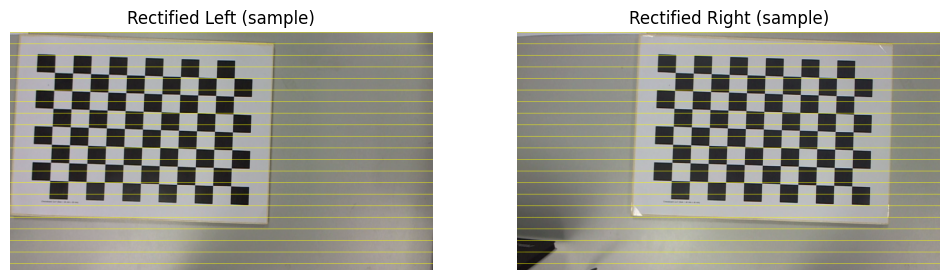

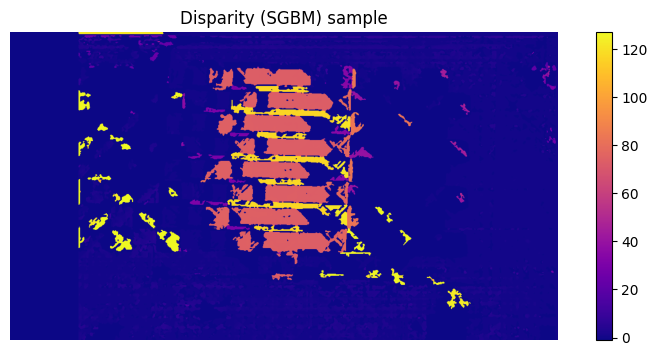

Saved /content/disp_sgbm.png
Valid 3D points (sample): 284055 Z range (m): -262.7128 inf
Saved /content/pointcloud_sample.ply


In [3]:
# FULL PIPELINE (run in Colab)
import cv2, numpy as np, os, pickle
import matplotlib.pyplot as plt

left_dir = '/content/leftcamera'
right_dir = '/content/rightcamera'
cb_cols = 11   # inner corners horizontally
cb_rows = 7    # inner corners vertically
square_size_m = 0.03
min_pairs_required = 8

# gather files
Lfiles = sorted([os.path.join(left_dir,f) for f in os.listdir(left_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
Rfiles = sorted([os.path.join(right_dir,f) for f in os.listdir(right_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])

print("Found", len(Lfiles), "left and", len(Rfiles), "right images.")
assert len(Lfiles) == len(Rfiles), "Left/right counts must match."

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
objp = np.zeros((cb_rows*cb_cols, 3), np.float32)
objp[:, :2] = np.mgrid[0:cb_cols, 0:cb_rows].T.reshape(-1,2) * square_size_m

objpoints, imgpointsL, imgpointsR = [], [], []

for lf, rf in zip(Lfiles, Rfiles):
    imgL = cv2.imread(lf); imgR = cv2.imread(rf)
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY); grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    foundL, cornersL = cv2.findChessboardCorners(grayL, (cb_cols, cb_rows),
                                                 flags=cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE)
    foundR, cornersR = cv2.findChessboardCorners(grayR, (cb_cols, cb_rows),
                                                 flags=cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE)
    if foundL and foundR:
        cornersL = cv2.cornerSubPix(grayL, cornersL, (11,11), (-1,-1), criteria)
        cornersR = cv2.cornerSubPix(grayR, cornersR, (11,11), (-1,-1), criteria)
        objpoints.append(objp); imgpointsL.append(cornersL); imgpointsR.append(cornersR)
    else:
        print("Chessboard not found in:", os.path.basename(lf), os.path.basename(rf))

print("Valid pairs detected:", len(objpoints))
if len(objpoints) < min_pairs_required:
    raise RuntimeError("Not enough valid pairs for stereo calibration. Need >= 8.")

# image size
h, w = cv2.imread(Lfiles[0]).shape[:2]
img_size = (w, h)
print("Image size:", img_size)

# individual calibration
retL, K1, d1, rvecs1, tvecs1 = cv2.calibrateCamera(objpoints, imgpointsL, img_size, None, None)
retR, K2, d2, rvecs2, tvecs2 = cv2.calibrateCamera(objpoints, imgpointsR, img_size, None, None)
print("Initial single-camera RMS:", retL, retR)

# stereo calibration
stereo_criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)
ret_stereo, K1, d1, K2, d2, R, T, E, F = cv2.stereoCalibrate(
    objpoints, imgpointsL, imgpointsR, K1, d1, K2, d2, img_size, criteria=stereo_criteria, flags=0
)
print("Stereo RMS reprojection error (ret_stereo):", ret_stereo)
print("Baseline T (metres):", T.ravel(), "||T|| =", np.linalg.norm(T))

# save calibration
params = {"K1":K1,"d1":d1,"K2":K2,"d2":d2,"R":R,"T":T,"E":E,"F":F,"image_size":img_size}
with open('/content/stereo_calib_params.pkl','wb') as f: pickle.dump(params, f)
print("Saved /content/stereo_calib_params.pkl")

# rectify
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(K1, d1, K2, d2, img_size, R, T, alpha=0)
map1x, map1y = cv2.initUndistortRectifyMap(K1, d1, R1, P1, img_size, cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(K2, d2, R2, P2, img_size, cv2.CV_32FC1)

# rectify first pair for a quick check
imgL = cv2.imread(Lfiles[0]); imgR = cv2.imread(Rfiles[0])
rectL = cv2.remap(imgL, map1x, map1y, cv2.INTER_LINEAR)
rectR = cv2.remap(imgR, map2x, map2y, cv2.INTER_LINEAR)

# draw horizontal lines for visual check
visL = rectL.copy(); visR = rectR.copy()
for y in range(0, h, max(20, h//20)):
    cv2.line(visL, (0,y), (w,y), (0,255,255), 1); cv2.line(visR, (0,y), (w,y), (0,255,255), 1)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(121); plt.title('Rectified Left (sample)'); plt.imshow(cv2.cvtColor(visL, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.subplot(122); plt.title('Rectified Right (sample)'); plt.imshow(cv2.cvtColor(visR, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.show()

# disparity (SGBM)
grayL = cv2.cvtColor(rectL, cv2.COLOR_BGR2GRAY); grayR = cv2.cvtColor(rectR, cv2.COLOR_BGR2GRAY)
numDisp = 128  # divisible by 16
stereo = cv2.StereoSGBM_create(minDisparity=0, numDisparities=numDisp, blockSize=5,
                               P1=8*3*5**2, P2=32*3*5**2, disp12MaxDiff=1,
                               uniquenessRatio=10, speckleWindowSize=100, speckleRange=32)
disp = stereo.compute(grayL, grayR).astype(np.float32) / 16.0

plt.figure(figsize=(10,4))
plt.imshow(disp, cmap='plasma'); plt.title('Disparity (SGBM) sample'); plt.colorbar(); plt.axis('off')
plt.show()

# save disparity normalized
disp_vis = np.copy(disp)
disp_vis[disp_vis < 0] = 0
disp_vis = (disp_vis - disp_vis.min()) / (disp_vis.max() - disp_vis.min() + 1e-8)
cv2.imwrite('/content/disp_sgbm.png', (disp_vis*255).astype('uint8'))
print("Saved /content/disp_sgbm.png")

# reproject to 3D (meters)
points_3d = cv2.reprojectImageTo3D(disp, Q)
mask = disp > disp.min()
print("Valid 3D points (sample):", np.sum(mask), "Z range (m):", np.min(points_3d[:,:,2][mask]), np.max(points_3d[:,:,2][mask]))

# save point cloud (PLY)
def save_ply(filename, img, points, mask):
    pts = points[mask]
    cols = img[mask][:, ::-1]  # BGR->RGB
    with open(filename, 'w') as f:
        f.write("ply\nformat ascii 1.0\n")
        f.write(f"element vertex {len(pts)}\n")
        f.write("property float x\nproperty float y\nproperty float z\n")
        f.write("property uchar red\nproperty uchar green\nproperty uchar blue\n")
        f.write("end_header\n")
        for p,c in zip(pts, cols):
            f.write(f"{p[0]} {p[1]} {p[2]} {int(c[0])} {int(c[1])} {int(c[2])}\n")
save_ply('/content/pointcloud_sample.ply', rectL, points_3d, mask)
print("Saved /content/pointcloud_sample.ply")


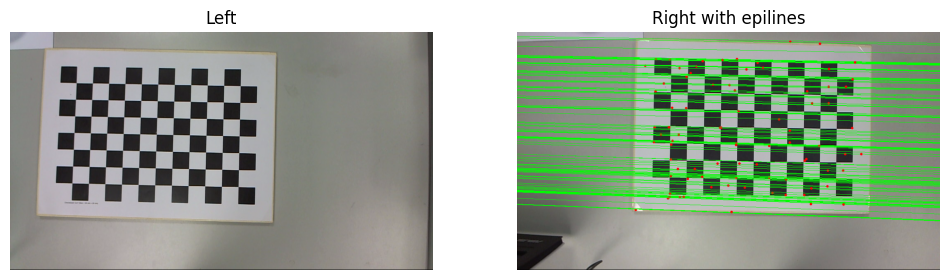

Number of good matches used: 144


In [4]:
# CELL A: SIFT matches + Fundamental matrix + epipolar lines (optional)
import cv2, numpy as np, os, matplotlib.pyplot as plt
left_dir = '/content/leftcamera'
right_dir = '/content/rightcamera'
# sample pair index (1-based filename) or 0-based list index
pair_idx = 0

Lfiles = sorted([os.path.join(left_dir,f) for f in os.listdir(left_dir) if f.lower().endswith(('.png','.jpg'))])
Rfiles = sorted([os.path.join(right_dir,f) for f in os.listdir(right_dir) if f.lower().endswith(('.png','.jpg'))])

img1 = cv2.imread(Lfiles[pair_idx]); img2 = cv2.imread(Rfiles[pair_idx])
g1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY); g2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(g1, None)
kp2, des2 = sift.detectAndCompute(g2, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

good = []
pts1 = []
pts2 = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1); pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# compute epilines for pts1 -> lines on img2
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1, F).reshape(-1,3)
img2e = img2.copy()
for r, pt in zip(lines2, pts2):
    a,b,c = r
    x0,y0 = 0, int(-c/b) if b!=0 else 0
    x1,y1 = img2.shape[1], int(-(c + a*img2.shape[1]) / b) if b!=0 else img2.shape[0]
    cv2.line(img2e, (x0,y0), (x1,y1), (0,255,0),1)
    cv2.circle(img2e, tuple(pt), 3, (0,0,255), -1)

plt.figure(figsize=(12,6))
plt.subplot(121); plt.title('Left'); plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.subplot(122); plt.title('Right with epilines'); plt.imshow(cv2.cvtColor(img2e, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.show()
print("Number of good matches used:", len(pts1))


In [5]:
# CELL B: Rectify ALL pairs and save
import os, pickle, cv2, numpy as np
left_dir = '/content/leftcamera'
right_dir = '/content/rightcamera'
outL = '/content/rectified_left'; outR = '/content/rectified_right'
os.makedirs(outL, exist_ok=True); os.makedirs(outR, exist_ok=True)

# load calibration params (must exist)
with open('/content/stereo_calib_params.pkl','rb') as f:
    calib = pickle.load(f)
K1, d1, K2, d2, R, T = calib['K1'], calib['d1'], calib['K2'], calib['d2'], calib['R'], calib['T']
img_size = calib['image_size']

R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(K1, d1, K2, d2, img_size, R, T, alpha=0)
map1x, map1y = cv2.initUndistortRectifyMap(K1, d1, R1, P1, img_size, cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(K2, d2, R2, P2, img_size, cv2.CV_32FC1)

Lfiles = sorted([os.path.join(left_dir,f) for f in os.listdir(left_dir) if f.lower().endswith(('.png','.jpg'))])
Rfiles = sorted([os.path.join(right_dir,f) for f in os.listdir(right_dir) if f.lower().endswith(('.png','.jpg'))])

for i,(lf,rf) in enumerate(zip(Lfiles,Rfiles), start=1):
    a = cv2.imread(lf); b = cv2.imread(rf)
    rA = cv2.remap(a, map1x, map1y, cv2.INTER_LINEAR)
    rB = cv2.remap(b, map2x, map2y, cv2.INTER_LINEAR)
    out1 = os.path.join(outL, f"Im_L_rect_{i:02d}.png")
    out2 = os.path.join(outR, f"Im_R_rect_{i:02d}.png")
    cv2.imwrite(out1, rA); cv2.imwrite(out2, rB)
print("Saved rectified images to:", outL, outR)
# also save Q for reprojection later
with open('/content/stereo_rectify_Q.pkl','wb') as f:
    pickle.dump({'Q':Q,'R1':R1,'R2':R2,'P1':P1,'P2':P2}, f)
print("Saved Q to /content/stereo_rectify_Q.pkl")


Saved rectified images to: /content/rectified_left /content/rectified_right
Saved Q to /content/stereo_rectify_Q.pkl


In [7]:
#Task4
# CELL C: Disparity for ALL rectified pairs (SGBM)
import cv2, numpy as np, os, pickle
rectL_dir = '/content/rectified_left'
rectR_dir = '/content/rectified_right'
out_disp_dir = '/content/disparity_vis'; out_disp_raw = '/content/disparity_raw'
os.makedirs(out_disp_dir, exist_ok=True); os.makedirs(out_disp_raw, exist_ok=True)

# load Q (we saved earlier)
with open('/content/stereo_rectify_Q.pkl','rb') as f:
    Q = pickle.load(f)['Q']

# stereo SGBM parameters (tune if needed)
numDisp = 128  # must be multiple of 16
stereo = cv2.StereoSGBM_create(minDisparity=0, numDisparities=numDisp, blockSize=5,
    P1=8*3*5**2, P2=32*3*5**2, disp12MaxDiff=1, uniquenessRatio=8, speckleWindowSize=100, speckleRange=32)

Lfiles = sorted([os.path.join(rectL_dir,f) for f in os.listdir(rectL_dir) if f.lower().endswith('.png')])
Rfiles = sorted([os.path.join(rectR_dir,f) for f in os.listdir(rectR_dir) if f.lower().endswith('.png')])

for i,(lf,rf) in enumerate(zip(Lfiles,Rfiles), start=1):
    imL = cv2.imread(lf, cv2.IMREAD_GRAYSCALE)
    imR = cv2.imread(rf, cv2.IMREAD_GRAYSCALE)
    disp16 = stereo.compute(imL, imR)     # int16 fixed-point (x16)
    disp = disp16.astype(np.float32) / 16.0
    # save raw
    np.save(os.path.join(out_disp_raw, f"disp_{i:02d}.npy"), disp)
    # normalized visualization
    disp_vis = disp.copy()
    disp_vis[disp_vis < 0] = 0
    disp_vis = (disp_vis - disp_vis.min()) / (disp_vis.max() - disp_vis.min() + 1e-8)
    cv2.imwrite(os.path.join(out_disp_dir, f"disp_vis_{i:02d}.png"), (disp_vis*255).astype(np.uint8))
print("Saved disparity visualizations to:", out_disp_dir)
print("Saved raw disparity .npy files to:", out_disp_raw)


Saved disparity visualizations to: /content/disparity_vis
Saved raw disparity .npy files to: /content/disparity_raw


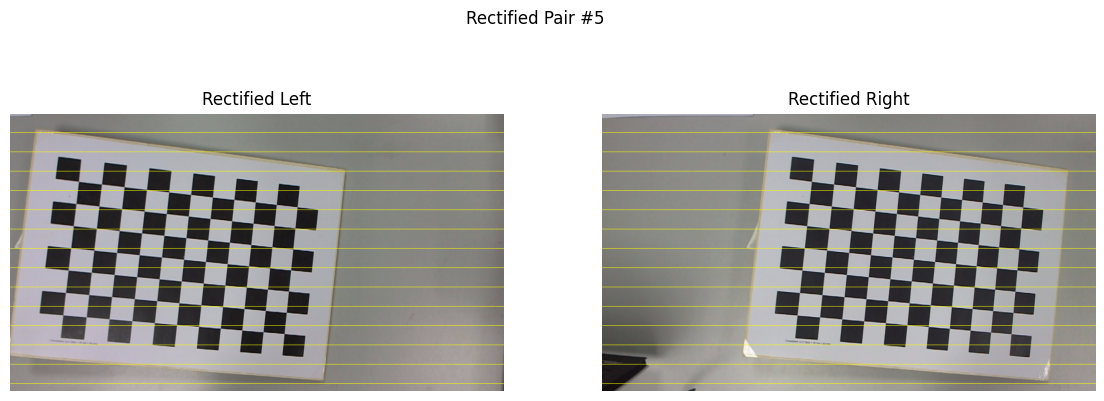

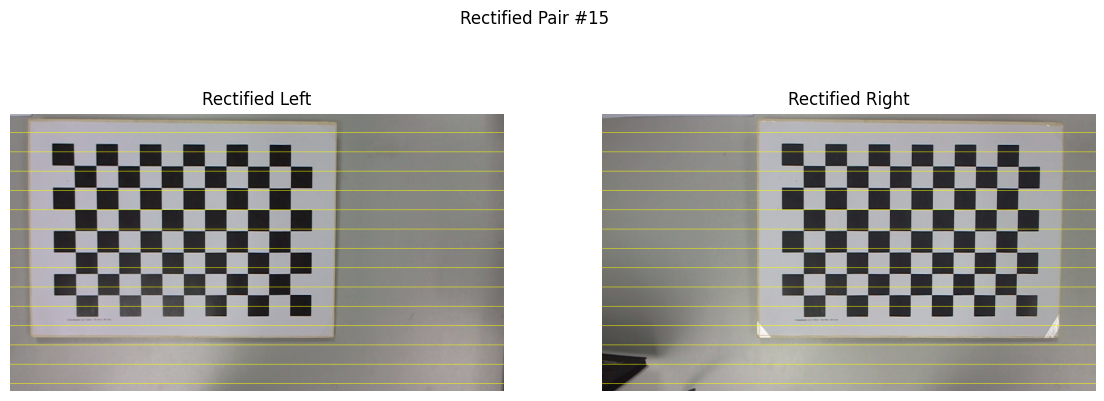

In [10]:
#tak3 output
# --- SHOW 2 RANDOM RECTIFIED PAIRS ---
import os, random, cv2
import matplotlib.pyplot as plt

rectL_dir = "/content/rectified_left"
rectR_dir = "/content/rectified_right"

Lfiles = sorted([os.path.join(rectL_dir,f) for f in os.listdir(rectL_dir) if f.endswith(".png")])
Rfiles = sorted([os.path.join(rectR_dir,f) for f in os.listdir(rectR_dir) if f.endswith(".png")])

# pick any 2 random indices
idxs = random.sample(range(len(Lfiles)), 2)

for idx in idxs:
    imgL = cv2.imread(Lfiles[idx])
    imgR = cv2.imread(Rfiles[idx])

    imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
    imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)

    # overlay horizontal lines for proof of rectification
    h, w = imgL.shape[:2]
    visL, visR = imgL.copy(), imgR.copy()
    for y in range(0, h, 40):
        cv2.line(visL, (0,y), (w,y), (255,255,0), 1)
        cv2.line(visR, (0,y), (w,y), (255,255,0), 1)

    plt.figure(figsize=(14,5))
    plt.suptitle(f"Rectified Pair #{idx+1}")
    plt.subplot(1,2,1); plt.imshow(visL); plt.axis('off'); plt.title("Rectified Left")
    plt.subplot(1,2,2); plt.imshow(visR); plt.axis('off'); plt.title("Rectified Right")
    plt.show()


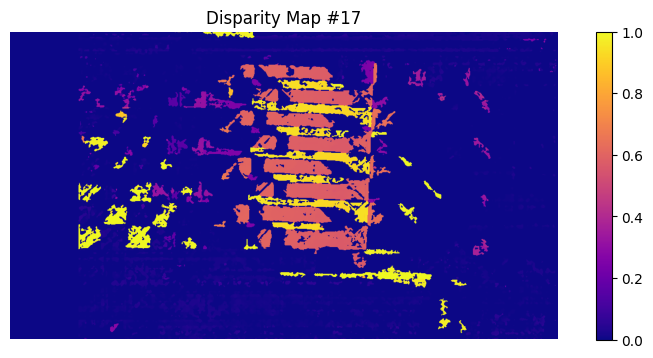

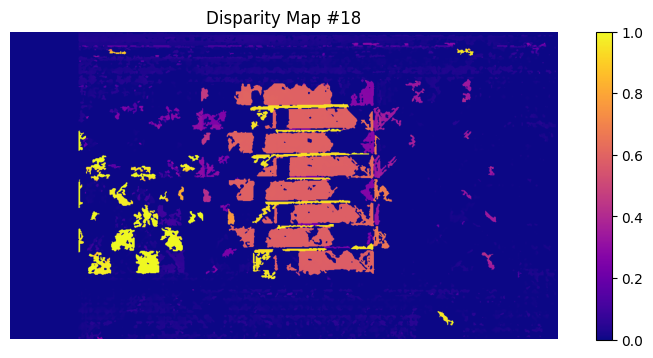

In [11]:
#task4 output
# --- SHOW 2 RANDOM DISPARITY MAPS ---
import os, random, numpy as np
import matplotlib.pyplot as plt

disp_dir = "/content/disparity_raw"
files = sorted([os.path.join(disp_dir,f) for f in os.listdir(disp_dir) if f.endswith(".npy")])

idxs = random.sample(range(len(files)), 2)

for idx in idxs:
    disp = np.load(files[idx])
    disp_vis = disp.copy()
    disp_vis[disp_vis < 0] = 0
    disp_vis = (disp_vis - disp_vis.min()) / (disp_vis.max() - disp_vis.min())

    plt.figure(figsize=(10,4))
    plt.title(f"Disparity Map #{idx+1}")
    plt.imshow(disp_vis, cmap='plasma')
    plt.axis('off')
    plt.colorbar()
    plt.show()


DP stereo completed rows=576 in 1105.5 s. Pair index=0


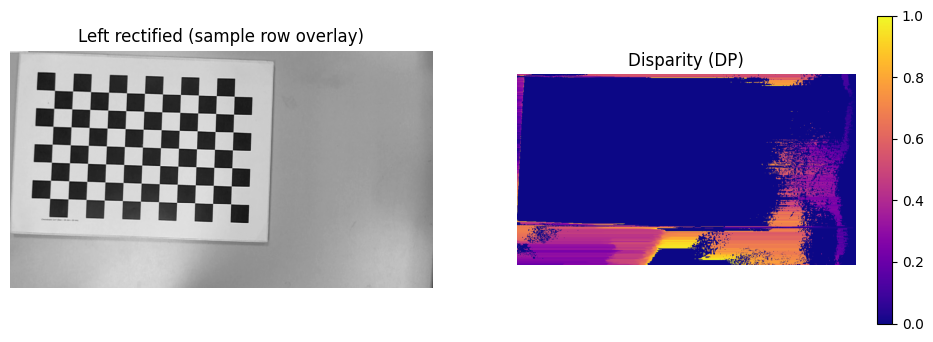

In [12]:
# === Task 5: Dynamic Programming stereo (full-image but optional row-subsampling) ===
import cv2, numpy as np, os, time
import matplotlib.pyplot as plt

# params
rectL_dir = '/content/rectified_left'
rectR_dir = '/content/rectified_right'

# choose pair index to process (0-based index among rectified filenames)
pair_index = 0         # change to process other pairs
process_all_rows = True  # False -> use 'row_step' to subsample rows (faster)
row_step = 4            # process every 4th row when not all rows
occlusion_cost = 15     # penalty for skipping a pixel (tune)
max_disparity = 200     # maximum disparity to consider (for speed and clipping)

# load images
Lfiles = sorted([os.path.join(rectL_dir,f) for f in os.listdir(rectL_dir) if f.lower().endswith('.png')])
Rfiles = sorted([os.path.join(rectR_dir,f) for f in os.listdir(rectR_dir) if f.lower().endswith('.png')])
assert len(Lfiles)>pair_index and len(Rfiles)>pair_index, "Rectified images missing or wrong index"

imgL = cv2.imread(Lfiles[pair_index], cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(Rfiles[pair_index], cv2.IMREAD_GRAYSCALE)
h, w = imgL.shape

# pre-allocate disparity map (float)
disp_dp = np.full((h, w), -1.0, dtype=np.float32)

rows = range(0, h) if process_all_rows else range(0, h, row_step)

t0 = time.time()
for r in rows:
    left_row = imgL[r].astype(np.int32)
    right_row = imgR[r].astype(np.int32)
    n = w
    m = w

    # build DP table: we only need two rows at a time if memory optimized, but use full table for clarity
    INF = 10**9
    dp = np.full((n+1, m+1), INF, dtype=np.int32)
    dp[0,0] = 0
    for i in range(1,n+1): dp[i,0] = dp[i-1,0] + occlusion_cost
    for j in range(1,m+1): dp[0,j] = dp[0,j-1] + occlusion_cost

    # cost function: absolute difference
    for i in range(1, n+1):
        Li = left_row[i-1]
        # loop right pixels
        # For speed, we can limit disparity search by only considering j such that |i - j| <= max_disparity
        jmin = 1
        jmax = m
        for j in range(jmin, jmax+1):
            match_cost = abs(Li - right_row[j-1])
            # three choices: match, occlude left, occlude right
            v_match = dp[i-1, j-1] + match_cost
            v_left_occl = dp[i-1, j] + occlusion_cost
            v_right_occl = dp[i, j-1] + occlusion_cost
            dp[i,j] = min(v_match, v_left_occl, v_right_occl)

    # backtrack to extract disparities for this row
    i, j = n, m
    disp_row = np.zeros(n, dtype=np.float32)
    while i>0 and j>0:
        match_cost = abs(left_row[i-1] - right_row[j-1])
        if dp[i,j] == dp[i-1,j-1] + match_cost:
            # matched: disparity = left_x - right_x
            disp = abs((i-1) - (j-1))
            # clip to max_disparity for stability
            if disp > max_disparity: disp = 0
            disp_row[i-1] = float(disp)
            i -= 1; j -= 1
        elif dp[i,j] == dp[i-1,j] + occlusion_cost:
            # left pixel occluded
            disp_row[i-1] = 0
            i -= 1
        else:
            # right occluded
            j -= 1
    # if remaining i>0 or j>0, mark as 0
    while i>0:
        disp_row[i-1] = 0
        i -= 1
    # save row into disparity map
    disp_dp[r,:] = disp_row

t1 = time.time()
print(f"DP stereo completed rows={len(list(rows))} in {t1-t0:.1f} s. Pair index={pair_index}")

# visualize
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Left rectified (sample row overlay)")
plt.imshow(imgL, cmap='gray'); plt.axis('off')
plt.subplot(1,2,2)
disp_vis = disp_dp.copy()
disp_vis[disp_vis < 0] = 0
if disp_vis.max() > 0:
    disp_vis = disp_vis / (disp_vis.max())
plt.title("Disparity (DP)")
plt.imshow(disp_vis, cmap='plasma'); plt.colorbar(); plt.axis('off')
plt.show()


SGBM computed for pair 0 in 0.33s


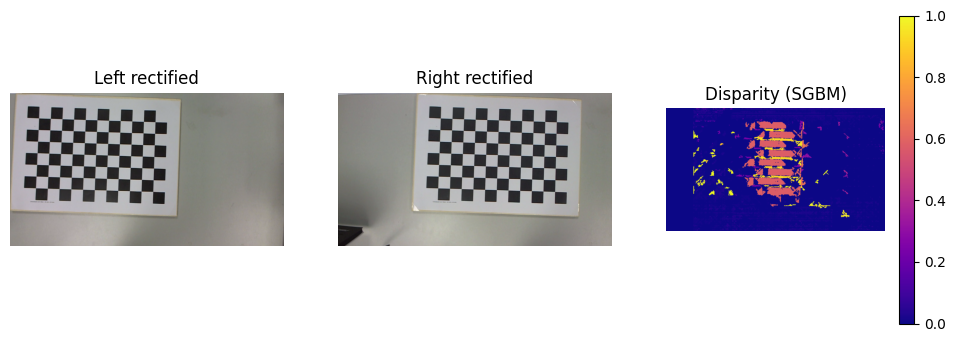


SGBM tuning hints (viva):
- Increase numDisparities if you expect larger depth range.
- Increase blockSize to reduce noise but lose detail.
- P1/P2 control smoothness; larger P2 -> smoother disparity.
- uniquenessRatio and speckle filters help reduce outliers.


In [13]:
# === Task 6: Stereo via StereoSGBM (Graph-cuts / SGM-like) for all rectified pairs ===
import cv2, numpy as np, os, matplotlib.pyplot as plt, time

rectL_dir = '/content/rectified_left'
rectR_dir = '/content/rectified_right'

Lfiles = sorted([os.path.join(rectL_dir,f) for f in os.listdir(rectL_dir) if f.lower().endswith('.png')])
Rfiles = sorted([os.path.join(rectR_dir,f) for f in os.listdir(rectR_dir) if f.lower().endswith('.png')])
assert len(Lfiles) == len(Rfiles) and len(Lfiles)>0

# StereoSGBM parameters (starting point; tune for your images)
minDisparity = 0
numDisparities = 128  # must be divisible by 16
blockSize = 5         # odd: 3..11 typical
P1 = 8 * 3 * blockSize**2
P2 = 32 * 3 * blockSize**2
disp12MaxDiff = 1
uniquenessRatio = 10
speckleWindowSize = 100
speckleRange = 32

stereo = cv2.StereoSGBM_create(
    minDisparity=minDisparity,
    numDisparities=numDisparities,
    blockSize=blockSize,
    P1=P1,
    P2=P2,
    disp12MaxDiff=disp12MaxDiff,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange
)

# run SGBM for a sample pair and visualize (fast path)
sample_idx = 0
t0 = time.time()
imgL = cv2.imread(Lfiles[sample_idx], cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(Rfiles[sample_idx], cv2.IMREAD_GRAYSCALE)
disp16 = stereo.compute(imgL, imgR)          # 16x fixed point
t1 = time.time()
disp = disp16.astype(np.float32) / 16.0
print(f"SGBM computed for pair {sample_idx} in {t1-t0:.2f}s")

# mask invalid disparities
disp_mask = disp.copy()
disp_mask[disp_mask < minDisparity] = minDisparity
disp_vis = (disp_mask - disp_mask.min()) / (disp_mask.max() - disp_mask.min() + 1e-8)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title('Left rectified'); plt.imshow(cv2.imread(Lfiles[sample_idx])[:,:,::-1]); plt.axis('off')
plt.subplot(1,3,2); plt.title('Right rectified'); plt.imshow(cv2.imread(Rfiles[sample_idx])[:,:,::-1]); plt.axis('off')
plt.subplot(1,3,3); plt.title('Disparity (SGBM)'); plt.imshow(disp_vis, cmap='plasma'); plt.colorbar(); plt.axis('off')
plt.show()

# OPTIONAL: compute SGBM for ALL pairs and save visuals (comment/uncomment to run)
save_all = False
out_vis_dir = '/content/sgbm_vis'; os.makedirs(out_vis_dir, exist_ok=True)
if save_all:
    for i, (lf, rf) in enumerate(zip(Lfiles, Rfiles), start=1):
        imgL = cv2.imread(lf, cv2.IMREAD_GRAYSCALE)
        imgR = cv2.imread(rf, cv2.IMREAD_GRAYSCALE)
        disp = stereo.compute(imgL, imgR).astype(np.float32) / 16.0
        disp_vis = disp.copy()
        disp_vis[disp_vis < minDisparity] = minDisparity
        disp_vis = (disp_vis - disp_vis.min()) / (disp_vis.max() - disp_vis.min() + 1e-8)
        outpath = os.path.join(out_vis_dir, f"sgbm_vis_{i:02d}.png")
        cv2.imwrite(outpath, (disp_vis*255).astype('uint8'))
    print("Saved SGBM visuals to", out_vis_dir)

# Print brief guidance for tuning (viva)
print("\nSGBM tuning hints (viva):")
print("- Increase numDisparities if you expect larger depth range.")
print("- Increase blockSize to reduce noise but lose detail.")
print("- P1/P2 control smoothness; larger P2 -> smoother disparity.")
print("- uniquenessRatio and speckle filters help reduce outliers.")
